In [ ]:
# load in the necessary functions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


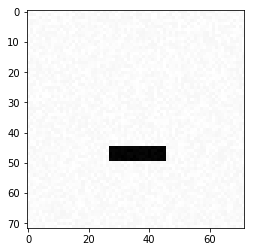

In [2]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

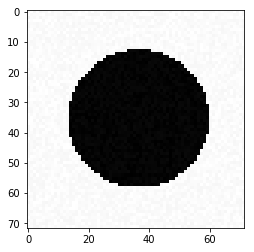

In [3]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

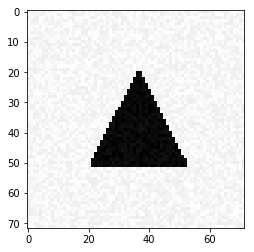

In [4]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [5]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [6]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3 Simple Classification

In [7]:
import keras
from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [8]:
# generate training data
[X_train, Y_train] = generate_dataset_classification(300, 20)
y_train = np_utils.to_categorical(Y_train, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


----------------------------------------------     Optimizer: SGD  -----------------------------------------------

In [109]:
# build model
model = Sequential()
model.add(Dense(3, input_shape=(5184,))) 
model.add(Activation('softmax'))

In [110]:
# optimizer 
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 0.2885 - acc: 0.3767
Epoch 2/10
300/300 [==============================] - 0s 85us/step - loss: 0.2665 - acc: 0.5200
Epoch 3/10
300/300 [==============================] - 0s 74us/step - loss: 0.2549 - acc: 0.5633
Epoch 4/10
300/300 [==============================] - 0s 86us/step - loss: 0.2495 - acc: 0.5933
Epoch 5/10
300/300 [==============================] - 0s 72us/step - loss: 0.2514 - acc: 0.5833
Epoch 6/10
300/300 [==============================] - 0s 79us/step - loss: 0.2434 - acc: 0.5967
Epoch 7/10
300/300 [==============================] - 0s 74us/step - loss: 0.2388 - acc: 0.6133
Epoch 8/10
300/300 [==============================] - 0s 79us/step - loss: 0.2332 - acc: 0.6133
Epoch 9/10
300/300 [==============================] - 0s 72us/step - loss: 0.1999 - acc: 0.6800
Epoch 10/10
300/300 [==============================] - 0s 76us/step - loss: 0.1990 - acc: 0.6633


In [111]:
# test the model
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

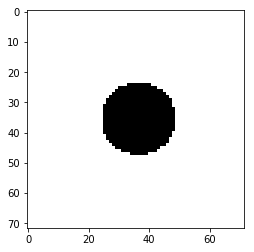

In [112]:
#
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

---------------------------------------------     Optimizer: Adam  -----------------------------------------------

In [123]:
# optimizer Adam
model_adam = Sequential()
model_adam.add(Dense(3, input_shape=(5184,))) 
model_adam.add(Activation('softmax')) 

# compile the model
model_adam.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# fit the model
model_adam.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 0.2768 - acc: 0.4333
Epoch 2/10
300/300 [==============================] - 0s 84us/step - loss: 0.2304 - acc: 0.5967
Epoch 3/10
300/300 [==============================] - 0s 88us/step - loss: 0.2163 - acc: 0.6333
Epoch 4/10
300/300 [==============================] - 0s 85us/step - loss: 0.1973 - acc: 0.6600
Epoch 5/10
300/300 [==============================] - 0s 84us/step - loss: 0.1931 - acc: 0.6700
Epoch 6/10
300/300 [==============================] - 0s 89us/step - loss: 0.1841 - acc: 0.6567
Epoch 7/10
300/300 [==============================] - 0s 81us/step - loss: 0.1844 - acc: 0.6600
Epoch 8/10
300/300 [==============================] - 0s 88us/step - loss: 0.1824 - acc: 0.6700
Epoch 9/10
300/300 [==============================] - 0s 95us/step - loss: 0.1926 - acc: 0.6600
Epoch 10/10
300/300 [==============================] - 0s 84us/step - loss: 0.1827 - acc: 0.6667


In [114]:
#
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

# 4 Visualization of the solution

In [115]:
# View the weights and bias
model_adam.get_weights()

[array([[-0.03002719, -0.00540226, -0.02511954],
        [-0.01413335,  0.02602842, -0.03156114],
        [ 0.02182801,  0.00938544, -0.01714955],
        ...,
        [ 0.00386203, -0.03240174,  0.011576  ],
        [ 0.01704544,  0.00441003,  0.01804487],
        [ 0.0185193 ,  0.01103716,  0.01110873]], dtype=float32),
 array([ 0.00133593,  0.00022453, -0.00122174], dtype=float32)]

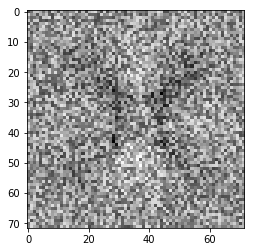

In [116]:
#  Rectangle
weight_rect = model_adam.get_weights()[0][:,0]
plt.imshow(weight_rect.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

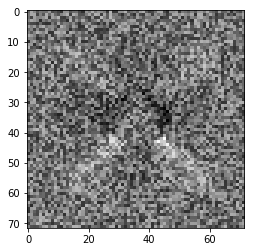

In [117]:
# Disk
weight_disk = model_adam.get_weights()[0][:,1]
plt.imshow(weight_disk.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

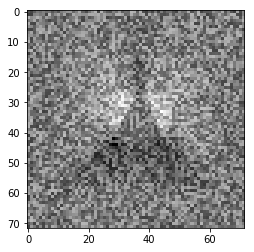

In [118]:
# Triangle
weight_tri = model_adam.get_weights()[0][:,2]
plt.imshow(weight_tri.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


# 5 A more difficult classification problem

In [36]:
#  Generate data
[X_train2, Y_train2] = generate_dataset_classification(300, 20, True)
[X_test2, Y_test2] = generate_test_set_classification()

# reformating the desired input
X_train2 = X_train2.reshape(X_train2.shape[0], IMAGE_SIZE , IMAGE_SIZE , 1)
X_train2 = X_train2.astype('float32')
print(X_train2.shape)

# reformating the desired output
Y_train2 = np_utils.to_categorical(Y_train2, 3)

# reformating the desired input for test
X_test2 = X_test2.reshape(X_test2.shape[0], IMAGE_SIZE , IMAGE_SIZE , 1)
X_test2 = X_test2.astype('float32')

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
(300, 72, 72, 1)


In [86]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization

In [120]:
# Build the model
model_conv = Sequential()

model_conv.add(Conv2D(32, (5, 5), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Flatten())
model_conv.add(Dense(3, activation='softmax'))

In [122]:
# Compile the model
model_conv.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# 'categorical_crossentropy'
# 'mean_squared_error'

# fit the model
model_conv.fit(X_train2, Y_train2, batch_size=32, epochs=10, verbose=1)

# evaluate the model
model_conv.evaluate(X_test2, Y_test2)

Epoch 1/10
300/300 [==============================] - 2s 6ms/step - loss: 0.2100 - acc: 0.3767
Epoch 2/10
300/300 [==============================] - 1s 2ms/step - loss: 0.2077 - acc: 0.3767
Epoch 3/10
300/300 [==============================] - 1s 2ms/step - loss: 0.2066 - acc: 0.3767
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.2037 - acc: 0.3800
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.2004 - acc: 0.3800
Epoch 6/10
300/300 [==============================] - 1s 3ms/step - loss: 0.1987 - acc: 0.3800
Epoch 7/10
300/300 [==============================] - 1s 3ms/step - loss: 0.1961 - acc: 0.3867
Epoch 8/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1936 - acc: 0.3900
Epoch 9/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1924 - acc: 0.4033
Epoch 10/10
300/300 [==============================] - 1s 2ms/step


[0.1999832914272944, 0.4000000007947286]

In [41]:
# Build the model
model_conv = Sequential()

model_conv.add(Conv2D(16, (5, 5), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Conv2D(16, (5, 5), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Flatten())
model_conv.add(Dense(3, activation='softmax'))

In [124]:
# Train and evaluate the model
model_conv.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model_conv.fit(X_train2, Y_train2, batch_size=32, epochs=10, verbose=1)

model_conv.evaluate(X_test2, Y_test2)

Epoch 1/10
300/300 [==============================] - 2s 6ms/step - loss: 0.1911 - acc: 0.4333
Epoch 2/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1900 - acc: 0.4833
Epoch 3/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1866 - acc: 0.4500
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1849 - acc: 0.4600
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1833 - acc: 0.4733
Epoch 6/10
300/300 [==============================] - 1s 3ms/step - loss: 0.1820 - acc: 0.4933
Epoch 7/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1810 - acc: 0.5267
Epoch 8/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1792 - acc: 0.5333
Epoch 9/10
300/300 [==============================] - 1s 2ms/step - loss: 0.1775 - acc: 0.5400
Epoch 10/10
300/300 [==============================] - 1s 2ms/step


[0.18706786572933198, 0.5066666658719381]

# 6 A regression problem

In [200]:
[X_train_reg, Y_train_reg] = generate_dataset_regression(400, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


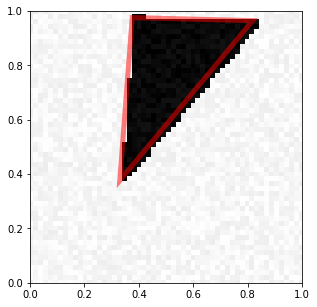

In [44]:
visualize_prediction(X_train_reg[0], Y_train_reg[0])

In [45]:
X_train_reg[0]    # example of X

array([0.96945093, 0.98687546, 0.93832222, ..., 0.94082208, 0.96048999,
       0.94096071])

In [46]:
Y_train_reg[0]    # example of Y

array([0.8188998 , 0.96452536, 0.3300047 , 0.37625288, 0.37578397,
       0.97574491])

In [201]:
[X_test_reg, Y_test_reg] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [ ]:
# As the model built didn't work very well after different temptations of tuning, i decided to sort the coordinations of vertices.
# I have tried two processus:   "normalization + sort", "sort + normalization"
# the Y_test will be applied the same normalization processus as the Y_train
# I chose "normalization + sort" in the end, because once sorted, it's not appropriate to apply the same normalization process for Y_test as
# that of Y_train, because the distributions of a same coordiante in Y_train and Y_test are more different after sorting

In [202]:
# reformating the desired input
X_train_reg = X_train_reg.reshape(X_train_reg.shape[0], IMAGE_SIZE , IMAGE_SIZE , 1)
X_train_reg = X_train_reg.astype('float32')
print(X_train_reg.shape)


# reformating the desired input for test
X_test_reg = X_test_reg.reshape(X_test_reg.shape[0], IMAGE_SIZE , IMAGE_SIZE , 1)
X_test_reg = X_test_reg.astype('float32')

(400, 72, 72, 1)


In [203]:
# Check the mean and variance of  y
np.mean(Y_train_reg_s[:,0])
np.std(Y_train_reg_s[:,0])

0.19739337304354265

In [204]:
# build a pipline to record the normalization of Y_train, and apply it on Y_test
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(Y_train_reg)

print(scaler.mean_)                                  
print(scaler.scale_)                                  

Y_train_reg_n = scaler.transform(Y_train_reg)                           
Y_test_reg_n = scaler.transform(Y_test_reg)  

[0.48777769 0.49266722 0.50323864 0.50005775 0.51388104 0.508111  ]
[0.28241299 0.29983038 0.28443955 0.28556976 0.28626556 0.29377005]


In [205]:
# Build the sort function 
def sort_coor(Y):
    Y_sorted = list(map(lambda i: np.array(sorted(Y[i].reshape(3,2), key= lambda x:x[0])).reshape(6), range(len(Y))))
    return np.array(Y_sorted)


In [206]:
# Sort the Y
Y_train_reg_s = sort_coor(Y_train_reg_n)
Y_test_reg_s = sort_coor(Y_test_reg_n)

In [209]:
# Build model
model_reg = Sequential()

model_reg.add(Conv2D(16, (5, 5), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model_reg.add(BatchNormalization())
model_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_reg.add(Flatten())
model_reg.add(Dense(6))

In [210]:
# Train and evaluate
model_reg.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
model_reg.fit(X_train_reg, Y_train_reg_s, batch_size=32, epochs=10, verbose=1)
model_reg.evaluate(X_test_reg, Y_test_reg_s)

Epoch 1/10
400/400 [==============================] - 8s 21ms/step - loss: 2.3880 - mean_squared_error: 2.3880
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.9847 - mean_squared_error: 0.9847
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.5519 - mean_squared_error: 0.5519
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.2860 - mean_squared_error: 0.2860
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1847 - mean_squared_error: 0.1847
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1198 - mean_squared_error: 0.1198
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0779 - mean_squared_error: 0.0779
Epoch 8/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 9/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0362 - mean_squared_error: 0.0362
Epoch 10/

[0.9802679363886515, 0.9802679363886515]

In [216]:
# Another try with more layers

model_reg = Sequential()

model_reg.add(Conv2D(16, (5, 5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model_reg.add(Activation('relu'))
model_reg.add(BatchNormalization())
model_reg.add(MaxPooling2D(pool_size=(2, 2)))

model_reg.add(Conv2D(16, (5, 5)))
model_reg.add(Activation('relu'))
#model_reg.add(BatchNormalization())
model_reg.add(MaxPooling2D(pool_size=(2, 2)))

model_reg.add(Flatten())   # 
model_reg.add(Dense(1024))

model_reg.add(Dense(128))

model_reg.add(Dense(6))

model_reg.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
model_reg.fit(X_train_reg, Y_train_reg_s, batch_size=32, epochs=15, verbose=1)
model_reg.evaluate(X_test_reg, Y_test_reg_s)

Epoch 1/15
400/400 [==============================] - 10s 25ms/step - loss: 56.9732 - mean_squared_error: 56.9732
Epoch 2/15
400/400 [==============================] - 3s 7ms/step - loss: 4.2169 - mean_squared_error: 4.2169
Epoch 3/15
400/400 [==============================] - 3s 7ms/step - loss: 1.1025 - mean_squared_error: 1.1025
Epoch 4/15
400/400 [==============================] - 3s 6ms/step - loss: 0.4346 - mean_squared_error: 0.4346
Epoch 5/15
400/400 [==============================] - 3s 7ms/step - loss: 0.3547 - mean_squared_error: 0.3547
Epoch 6/15
400/400 [==============================] - 3s 6ms/step - loss: 0.2650 - mean_squared_error: 0.2650
Epoch 7/15
400/400 [==============================] - 3s 6ms/step - loss: 0.2271 - mean_squared_error: 0.2271
Epoch 8/15
400/400 [==============================] - 3s 7ms/step - loss: 0.1937 - mean_squared_error: 0.1937
Epoch 9/15
400/400 [==============================] - 3s 6ms/step - loss: 0.1686 - mean_squared_error: 0.1686
Epoch 

[0.42120444933573403, 0.42120444933573403]

In [ ]:
# The mean square error for test set is still somehow big, but improved

In [ ]:
# I tried to use GridSearchCV to tune all the parameters, but the computations were too long, so i abondoned it.

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

def create_model():
    # create model
    model_reg = Sequential()
    model_reg.add(Conv2D(16, (7, 7), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model_reg.add(BatchNormalization())
    model_reg.add(MaxPooling2D(pool_size=(2, 2)))
    model_reg.add(Conv2D(32, (7, 7), activation='relu'))
    model_reg.add(BatchNormalization())
    model_reg.add(MaxPooling2D(pool_size=(2, 2)))
    model_reg.add(Flatten())   # 
    model_reg.add(Dense(1024, kernel_initializer='normal', activation = 'relu'))
    model_reg.add(Dense(128, kernel_initializer='normal', activation = 'relu'))
    model_reg.add(Dense(6, kernel_initializer='normal'))
    # Compile model    
    model_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model_reg

     # fix random seed for reproducibility
seed = 7
np.random.seed(seed)

    # create model
model_reg = KerasRegressor(build_fn=create_model, verbose=0)

    # define the grid search parameters
batch_size = [20, 30, 40]
epochs = [10, 15, 20]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model_reg, param_grid=param_grid )
grid_result = grid.fit(X_train_reg, Y_train_reg_s)

    # summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# 7 Image Denoising

In [223]:
import random
def generate_a_triangle_new(free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    noise=random.randint(1,41)
    image1 = generate_a_drawing(figsize, U, V, noise)
    image2 = generate_a_drawing(figsize, U, V, 0)
    return [image1,image2]


In [224]:
def generate_dataset(nb_sample):
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_sample,im_size])
    Y = np.zeros([nb_sample, im_size])
    NOISE=np.zeros(nb_sample)
    for i in range(nb_sample):
        noise=random.randint(1,41)
        if i % 10 == 0:
            print(i)
        X[i] = generate_a_triangle_new()[0]
        Y[i]= generate_a_triangle_new()[1]
        NOISE[i]=noise
    Noise=max(NOISE)
    X = (X + Noise) / (255 + 2 * Noise)
    Y=Y/255    
    return [X,Y]


In [235]:
[X_train_de,Y_train_de]=generate_dataset(300)
[X_test_de,Y_test_de]=generate_dataset(300)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [233]:
# reformating the desired input
#X_train_de = X_train_de.reshape(X_train_de.shape[0], IMAGE_SIZE , IMAGE_SIZE , 1)
#X_train_de = X_train_de.astype('float32')
#print(X_train_reg.shape)


# reformating the desired input for test
#X_test_de = X_test_de.reshape(X_test_de.shape[0], IMAGE_SIZE , IMAGE_SIZE , 1)
#X_test_de = X_test_de.astype('float32')

In [241]:
# Build the model
model_de = Sequential()

model_de.add(Dense(128, input_shape=( 300, 5184)))
model_de.add(Dense(128))
model_de.add(Dense(5184))

In [242]:
# Test the model
model_de.compile(loss='mean_squared_error',optimizer="adam", metrics=['mse'])
model_reg.fit(X_train_de, Y_train_de, batch_size=32, epochs=15, verbose=1)
model_reg.evaluate(X_test_de, Y_test_de)

ValueError: Error when checking input: expected conv2d_183_input to have 4 dimensions, but got array with shape (300, 5184)